# GS - 2° Semestre
#### Ana Luísa Elias - RM: 93686
#### Julio Cesar Lopes Batista


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import requests
import cv2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [9]:
TAMANHO_IMG = 160
FORMATO_IMG = (TAMANHO_IMG, TAMANHO_IMG, 3)
TAMANHO_LOTE = 32


(ds_treino, ds_validacao, ds_teste), metadados = tfds.load(
    'citrus_leaves',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

numero_classes = metadados.features['label'].num_classes
print(f"Dataset 'citrus_leaves' carregado. Número de classes: {numero_classes}")

Dataset 'citrus_leaves' carregado. Número de classes: 4


In [10]:
def pre_processar_com_opencv(imagem, rotulo):
    imagem_np = imagem.numpy()


    imagem_redimensionada = cv2.resize(imagem_np, (TAMANHO_IMG, TAMANHO_IMG))

    imagem_normalizada = imagem_redimensionada / 255.0

    return imagem_normalizada, rotulo

def wrapper_tf_opencv(imagem, rotulo):

    [imagem, rotulo] = tf.py_function(pre_processar_com_opencv,
                                  [imagem, rotulo],
                                  [tf.float32, tf.int64])

    imagem.set_shape(FORMATO_IMG)
    rotulo.set_shape([])
    return imagem, rotulo

lotes_treino = ds_treino.map(wrapper_tf_opencv).batch(TAMANHO_LOTE)
lotes_validacao = ds_validacao.map(wrapper_tf_opencv).batch(TAMANHO_LOTE)
lotes_teste = ds_teste.map(wrapper_tf_opencv).batch(TAMANHO_LOTE)

In [11]:
modelo_base = MobileNetV2(input_shape=FORMATO_IMG,
                          include_top=False,
                          weights='imagenet')
modelo_base.trainable = False

In [12]:
modelo = Sequential([
    modelo_base,
    GlobalAveragePooling2D(),
    Dense(numero_classes, activation='softmax')
])
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', verbose=1)
]

historico = modelo.fit(lotes_treino,
                       epochs=20,
                       validation_data=lotes_validacao,
                       callbacks=callbacks)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 896ms/step - accuracy: 0.3157 - loss: 1.5066 - val_accuracy: 0.5167 - val_loss: 1.0006
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6393 - loss: 0.8833 - val_accuracy: 0.6167 - val_loss: 0.7427
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7360 - loss: 0.6604 - val_accuracy: 0.7167 - val_loss: 0.6013
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7837 - loss: 0.5445 - val_accuracy: 0.7500 - val_loss: 0.5329
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8402 - loss: 0.4712 - val_accuracy: 0.8000 - val_loss: 0.4895
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8549 - loss: 0.4182 - val_accuracy: 0.8500 - val_loss: 0.4585
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8791 - loss: 0.3772 - val_accuracy: 0.8500 - val_loss: 0.4359
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9055 - loss: 0.3442 - val_accuracy: 0.8500 -

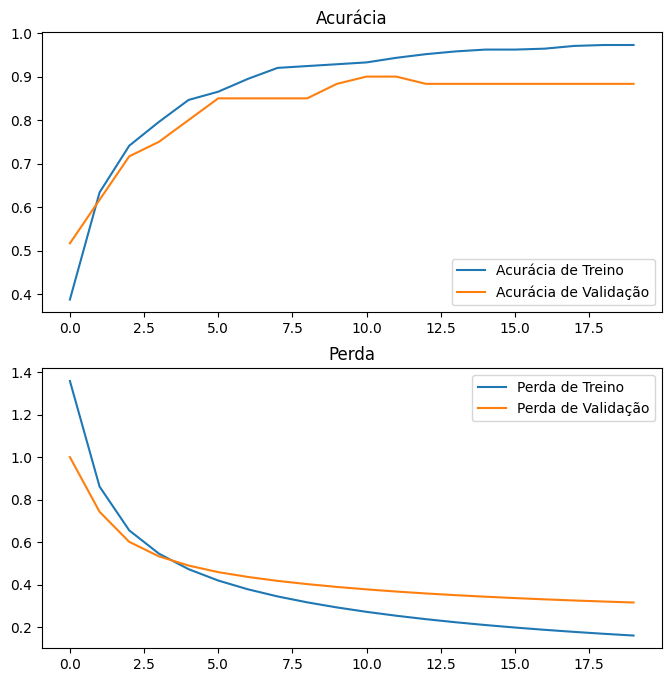

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8792 - loss: 0.3823
Acurácia no Teste: 88.14%


In [13]:
acuracia = historico.history['accuracy']
acuracia_validacao = historico.history['val_accuracy']
perda = historico.history['loss']
perda_validacao = historico.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acuracia, label='Acurácia de Treino')
plt.plot(acuracia_validacao, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia')

plt.subplot(2, 1, 2)
plt.plot(perda, label='Perda de Treino')
plt.plot(perda_validacao, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda')
plt.show()

perda_teste, acuracia_teste = modelo.evaluate(lotes_teste)
print(f"Acurácia no Teste: {acuracia_teste * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
A imagem foi classificada como: canker


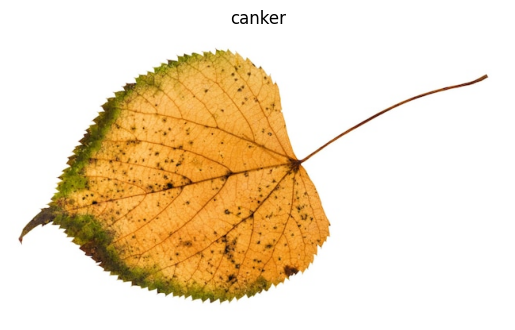

In [14]:
try:
    url = 'https://img.freepik.com/fotos-premium/ folha-podre-caida-de-tilia-isolada_696657-8296.jpg'
    local_img_path = 'imagem_para_classificar.jpg' # Nome do arquivo que vamos salvar no Colab

    # Baixa o conteúdo da URL
    response = requests.get(url)

    # Salva o conteúdo em um arquivo local
    with open(local_img_path, 'wb') as f:
        f.write(response.content)
    img = cv2.imread(local_img_path)

    img_resized = cv2.resize(img, (TAMANHO_IMG, TAMANHO_IMG))
    img_normalized = img_resized / 255.0

    img_batch = np.expand_dims(img_normalized, axis=0)

    prediction = modelo.predict(img_batch)

    class_names = metadados.features['label'].names
    predicted_class = class_names[np.argmax(prediction)]

    print(f"A imagem foi classificada como: {predicted_class}")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"Não foi possível classificar. (Ajuste o 'img_path' para uma imagem válida.) ",e)